## imports

In [ ]:
!pip install morfeusz2
import morfeusz2
morf = morfeusz2.Morfeusz()
import pandas as pd
import numpy as np
import re

import string
from string import ascii_lowercase
from sklearn.metrics import f1_score, confusion_matrix

!pip install emoji
import emoji
from string import punctuation
import unicodedata
import csv
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree._tree import TREE_LEAF

!pip install gdown

from sklearn import svm
from sklearn.linear_model import LogisticRegression

## download raw data

In [ ]:
!gdown --id 1kbYmGkMsQGVBdnDStxx3nz79WNh5JXy7 # training_set_clean_only_text.txt
!gdown --id 1XP30I7gKxhY1jOCOFlcIWDQDnZ3Qk9rZ # training_set_clean_only_tags.txt
!gdown --id 1z0Laz8jCGR-GQcMNL2_qKsGnbL4VRRCY # test_set_clean_only_text.txt
!gdown --id 1o_XRCnKlScCrZRk5suzjwzljT7YonQ2q # test_set_clean_only_tags.txt

Downloading...
From: https://drive.google.com/uc?id=1kbYmGkMsQGVBdnDStxx3nz79WNh5JXy7
To: /content/training_set_clean_only_text.txt
100% 1.00M/1.00M [00:00<00:00, 25.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XP30I7gKxhY1jOCOFlcIWDQDnZ3Qk9rZ
To: /content/training_set_clean_only_tags.txt
100% 30.1k/30.1k [00:00<00:00, 33.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z0Laz8jCGR-GQcMNL2_qKsGnbL4VRRCY
To: /content/test_set_clean_only_text.txt
100% 99.7k/99.7k [00:00<00:00, 8.08MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o_XRCnKlScCrZRk5suzjwzljT7YonQ2q
To: /content/test_set_clean_only_tags.txt
100% 3.00k/3.00k [00:00<00:00, 3.44MB/s]


In [ ]:
def read_file(file_name): # read given file and create list of phrases
  lines = []
  with open(file_name, encoding="UTF-8-SIG") as text:
    for line in text:
      lines.append(line[:-1])
  return lines

  # merge texts with labels
def merge_lists(list1, list2):
  merged = []
  for i in range(len(list1)):
    merged.append([list1[i], list2[i]])
  return merged


In [ ]:
text = read_file('training_set_clean_only_text.txt')
labels = read_file('training_set_clean_only_tags.txt')

texts_labels = merge_lists(text, labels)

text_test = read_file('test_set_clean_only_text.txt')
labels_test = read_file('test_set_clean_only_tags.txt')

texts_labels_test = merge_lists(text_test, labels_test)

In [ ]:
texts_labels[:10]

[['Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi.',
  '0'],
 ['@anonymized_account @anonymized_account Brawo ty Daria kibic ma być na dobre i złe',
  '0'],
 ['@anonymized_account @anonymized_account Super, polski premier składa kwiaty na grobach kolaborantów. Ale doczekaliśmy czasów.',
  '0'],
 ['@anonymized_account @anonymized_account Musi. Innej drogi nie mamy.', '0'],
 ['Odrzut natychmiastowy, kwaśna mina, mam problem', '0'],
 ['Jaki on był fajny xdd pamiętam, że spóźniłam się na jego pierwsze zajęcia i to sporo i za karę kazał mi usiąść w pierwszej ławce XD',
  '0'],
 ['@anonymized_account No nie ma u nas szczęścia 😉', '0'],
 ['@anonymized_account Dawno kogoś tak wrednego nie widziałam xd', '0'],
 ['@anonymized_account @anonymized_account Zaległości były, ale ważne czy były wezwania do zapłaty z których się klub nie wywiązał.',
  '0'],
 ['@anonymized_account @anonymized_account @anonymized_account Gdzie jest @anonymized_account . Brudziński jesteś kł

In [ ]:
texts_labels_test[:10]

[['@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok.',
  '0'],
 ["@anonymized_account @anonymized_account Ale on tu nie miał szans jej zagrania, a ta 'proba' to czysta prowizorka.",
  '0'],
 ['@anonymized_account No czy Prezes nie miał racji, mówiąc,ze to są zdradzieckie mordy? No czy nie miał racji?😁😁',
  '0'],
 ['@anonymized_account @anonymized_account Przecież to nawet nie jest przewrotka 😂',
  '0'],
 ['@anonymized_account @anonymized_account Owszem podatki tak. Ale nie w takich okolicznościach. Czemu Małysza odpalili z teamu Orlen?',
  '0'],
 ['@anonymized_account @anonymized_account skąd wiesz jaki Skendija ma budżet skoro mówisz że jest bogatsza ? Tylko dwóch zawodników ponoć dobrze zarabia.',
  '0'],
 ['Z tego, co widzę, to kibice Widzewa mają szczęście, że trwa mundial. Dzięki temu ogólnopolska szydera jest tylko z Argentyny i Messiego.',
  '0'],
 ['@anonymized_account @anonymized_account @anonymized_account Na utrzymanie własnej ar

In [ ]:
print(f'number of sentences in training set {len(texts_labels)}')
print(f'number of sentences in test set {len(texts_labels_test)}')

number of sentences in training set 10041
number of sentences in test set 1000


## processing

In [ ]:
not_wanted_words = ['@anonymized_account']
def processing_basic(texts, not_wanted_words): # create corpuse for hate, normal and both
  k=0
  corpus_normal = {}
  corpus_hate = {}
  corpus_whole = {}
  normal_num = 0
  hate_num = 0

  text_i = 0
  for text in texts:
    text_i +=1
    # if text_i == 100: break
    # print()
    words = text[0].split()
    label = text[1]

    for word in words:
      if word not in corpus_whole:
        corpus_whole[word] = 1
      else:
        corpus_whole[word] = corpus_whole[word] + 1

      if label == '0':
        if word not in corpus_normal:
          corpus_normal[word] = 1
        else:
          corpus_normal[word] = corpus_normal[word] + 1            
      if label == '1':
        if word not in corpus_hate:
          corpus_hate[word] = 1
        else:
          corpus_hate[word] = corpus_hate[word] + 1

  #   k+=1
  #   # if k==1: break
  return corpus_whole, corpus_hate, corpus_normal
  # print(text)

corpus_whole_no_process, corpus_hate_no_process, corpus_normal_no_process = processing_basic(texts_labels, not_wanted_words)

In [ ]:
print('length of corpuses whole normal hate with no processing is added')
print(len(corpus_whole_no_process), len(corpus_normal_no_process), len(corpus_hate_no_process))

length of corpuses whole normal hate with no processing is added
31485 29190 4307


In [ ]:
emojis_to_words = {'CONFOUNDED FACE': 'zmieszanie',
                  'CRYING FACE': 'płacz',
                  'DISAPPOINTED BUT RELIEVED FACE': 'rozczarowanie',
                  'DISAPPOINTED FACE': 'rozczarowanie',
                  'EXPRESSIONLESS FACE': 'bezwyrazowy',
                  'FACE SAVOURING DELICIOUS FOOD': 'pyszności',
                  'FACE SCREAMING IN FEAR': 'strach',
                  'FACE THROWING A KISS': 'pocałunek',
                  'FACE WITH COLD SWEAT': 'stres',
                  'FACE WITH MEDICAL MASK': 'maska',
                  'FACE WITH OK GESTURE': 'ok',
                  'FACE WITH OPEN MOUTH': 'zdziwienie',
                  'FACE WITH STUCK-OUT TONGUE': 'język',
                  'FACE WITH STUCK-OUT TONGUE AND TIGHTLY-CLOSED EYES': 'język',
                  'FACE WITH STUCK-OUT TONGUE AND WINKING EYE': 'język',
                  'FACE WITH TEARS OF JOY': 'radość',
                  'FEARFUL FACE': 'strach',
                  'FLUSHED FACE': 'zaczerwienienie',
                  'GRIMACING FACE': 'grymas',
                  'GRINNING FACE': 'uśmiech',
                  'GRINNING FACE WITH SMILING EYES': 'uśmiech',
                  'HAPPY PERSON RAISING ONE HAND': 'radość',
                  'HEAR-NO-EVIL MONKEY': 'małpka',
                  'HUSHED FACE': 'uciszenie',
                  'LOUDLY CRYING FACE': 'płacz',
                  'NEUTRAL FACE': 'neutralność',
                  'PENSIVE FACE': 'zamyślenie',
                  'PERSEVERING FACE': 'wytrwałość',
                  'PERSON BOWING DEEPLY': 'ukłon',
                  'PERSON RAISING BOTH HANDS IN CELEBRATION': 'radość',
                  'PERSON WITH FOLDED HANDS': 'ok',
                  'POUTING FACE': 'dąsanie',
                  'SEE-NO-EVIL MONKEY': 'małpka',
                  'SLIGHTLY SMILING FACE': 'uśmiech',
                  'SMILING FACE WITH HALO': 'uśmiech',
                  'SMILING FACE WITH HEART-SHAPED EYES': 'miłość',
                  'SMILING FACE WITH OPEN MOUTH': 'uśmiech',
                  'SMILING FACE WITH OPEN MOUTH AND COLD SWEAT': 'uśmiech',
                  'SMILING FACE WITH OPEN MOUTH AND SMILING EYES': 'uśmiech',
                  'SMILING FACE WITH OPEN MOUTH AND TIGHTLY-CLOSED EYES': 'uśmiech',
                  'SMILING FACE WITH SMILING EYES': 'uśmiech',
                  'SMILING FACE WITH SUNGLASSES': 'uśmiech',
                  'SPEAK-NO-EVIL MONKEY': 'małpka',
                  'UNAMUSED FACE': 'nierozbawienie',
                  'UPSIDE-DOWN FACE': 'uśmiech',
                  'WEARY FACE': 'zmęczenie',
                  'WINKING FACE': 'mrugnięcie'}

In [ ]:
not_wanted_words = ['@anonymized_account', 'account', 'anonymized' ]

emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U0001F700-\U0001F77F"  # alchemical symbols
          u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
          u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
          u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
          u"\U0001FA00-\U0001FA6F"  # Chess Symbols
          u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
          u"\U00002702-\U000027B0"  # Dingbats
          u"\U000024C2-\U0001F251" 
                            "]+", flags=re.UNICODE)

only_faces_emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
                            "]+", flags=re.UNICODE)

def word_process_with_emoji(word, previous_word=''):
  if word in not_wanted_words:
    return False

  if emoji_pattern.match(word):
    # print(word)
    return False
  if only_faces_emoji_pattern.match(word):
    word = unicodedata.name(word)
    if word in emojis_to_words: 
      # print(word)
      word = emojis_to_words[word]
    else: return False
    if word == previous_word:
      return False
    return word
  word = word.lower()

  analysis = morf.analyse(word)
  for interpretation in analysis:
    # print(interpretation[2][1].split(':')[0])
    word = interpretation[2][1].split(':')[0]
    break #take most common word
    # print(interpretation[2][1])
  word = word.lower()
  if len(word)==0:
    return False
  return word

In [ ]:

def clean_dataset(dataset, return_label=False, show_hate=False, mul_hate=False):
  dataset_clean = []
  add_hate = 1
  if mul_hate: add_hate=2
  corpus_normal, corpus_hate, corpus_whole = {}, {}, {}
  normal_num, hate_num = 0, 0
  re_split = re.compile(r'[\s{}]+'.format(re.escape(punctuation)))
  for line_label in dataset:
    line = line_label[0]
    label = line_label[1]
    row = []
    words = re_split.split(line)
    if words[0] == 'RT': 
      continue
    new_words = []
    for word in words:
      if len(word) == 0: continue
      if not emoji_pattern.match(word) and not only_faces_emoji_pattern.match(word):
        new_words.append(word)
      elif len(word) == 1:
        new_words.append(word)
      else:
        word = emoji.get_emoji_regexp().split(word)
        word = [i for i in word if len(i)>0]
        new_words += word

    previous_word = ''
    for word in new_words:
      word = word_process_with_emoji(word, previous_word)
      if word != False:
        previous_word = word
      if word != False: 
        row.append(word)
    for word in row:
      if word not in corpus_whole:
          corpus_whole[word] = 1
      else:
        corpus_whole[word] = corpus_whole[word] + 1
      if label == '0':
        if word not in corpus_normal:
          corpus_normal[word] = 1
        else:
          corpus_normal[word] = corpus_normal[word] + 1            
      if label == '1':
        if word not in corpus_hate:
          corpus_hate[word] = add_hate
        else:
          corpus_hate[word] = corpus_hate[word] + add_hate

    if return_label: dataset_clean.append([' '.join(row), label])
    else: dataset_clean.append(' '.join(row))
    # print()
  return dataset_clean, corpus_whole, corpus_hate, corpus_normal


In [ ]:
clean_train, corpus_whole, corpus_hate, corpus_normal = clean_dataset(texts_labels)
clean_test, corpus_whole_test, corpus_hate_test, corpus_normal_test = clean_dataset(texts_labels_test, return_label=True)

In [ ]:
clean_train[:10]

['dla ja faworyt do tytuł być cracovia zobaczyć czy typ się sprawdzić',
 'brawo ty daria kibic mój bycie na dobry i zły',
 'super polski premier składać kwiat na grób kolaborant ale doczekać czas',
 'musieć inny drogi nie mama',
 'odrzut natychmiastowy kwaśny mina mamić problem',
 'jaki on być fajny xdd pamiętać że spóźnić się na on pierwszy zająć i to sporo i za kara kazać ja usiąść w pierwszy ławka xd',
 'no nie mój u my szczęście',
 'dawno kto tak wredny nie widzieć xd',
 'zaległość były ale ważny czy były wezwanie do zapłata z który się klub nie wywiązać',
 'gdzie być brudziński być kłamca i marny kutas']

In [ ]:
clean_test[:10]

[['spoko jak im duda z morawiecki zamówić po pięć piwo to wszystek być oko',
  '0'],
 ['ale on tu nie miał szansa jej zagranie a ten proba to czysta prowizorka',
  '0'],
 ['no czy prezes nie miał racja mówić z to być zdradziecki mord no czy nie miał racja',
  '0'],
 ['przecież to nawet nie być przewrotka', '0'],
 ['owszem podatek tak ale nie w taki okoliczność czemu małysza odpalić z team orlen',
  '0'],
 ['skąd wiedzieć jaki skendija mój budżet skoro mówić że być bogaty tylko dwa zawodnik ponoć dobrze zarabiać',
  '0'],
 ['z to co widzieć to kibic widzew maja szczęście że trwać mundial dzięki temu ogólnopolski szydera być tylko z argentyna i messiego',
  '0'],
 ['na utrzymać własny armia 2 pkb tył że teraz to jednać wielki ściema', '0'],
 ['przypomnieć ja z musieć jeszcze suszarka spakować', '0'],
 ['czy adam już nie żyć jeśli tak to jak rozwiązać on wątek nadobreinazłe',
  '0']]

In [ ]:
# large cut in words number
print('length of corpuses whole normal hate with processing is added')
print(len(corpus_whole), len(corpus_normal), len(corpus_hate))

length of corpuses whole normal hate with processing is added
13760 13004 2694


## naive bayes

In [ ]:
def naive_bayes_clf(sent, corpus_normal, corpus_hate, hate_strong=False):
  words_sent = sent.split()
  p_normal = np.log(1/len(corpus_normal))
  p_hate = np.log(1/len(corpus_hate))
  predict = 0 #normal 0, hate 1

  for word in words_sent:
    if hate_strong:  
      if (word not in corpus_normal) and (word in corpus_hate):
        if corpus_hate[word] >=10: return 1
      if (word in corpus_normal) and (word in corpus_hate):
        if corpus_hate[word] >=10 and corpus_normal[word]<2 : return 1
    if word in corpus_normal:
      p_normal += np.log(corpus_normal[word])
    else:
      p_normal += np.log(1/len(corpus_normal))
    if word in corpus_hate:
      p_hate += np.log(corpus_hate[word])
    else:
      p_hate += np.log(1/len(corpus_hate))

  if p_normal > p_hate:
    return 0
  else: 
    return 1

In [ ]:
def test_naive_bayes_clf(sents, corpus_normal, corpus_hate, hate_strong=False):

  total_num = 0
  correct_pred = 0
  normal_num = 0
  normal_corr = 0
  hate_num = 0
  hate_corr = 0
  y_real, y_pred = [], []
  for sent in sents:
    pred = naive_bayes_clf(sent[0], corpus_normal, corpus_hate, hate_strong)
    if pred == None: continue
    y_pred.append(pred)
    if sent[1] == '0':
      y_real.append(0)
      normal_num +=1
    else:
      y_real.append(1)
      hate_num +=1

    if sent[1] == '0' and pred == 0:
      correct_pred+=1
      normal_corr+=1
    if sent[1] != '0' and pred == 1:
      correct_pred +=1
      hate_corr+=1
      print(sent[0])
    total_num+=1

  print(f'precision {hate_corr/sum(y_pred)}')
  print(f'recall {hate_corr/ (hate_corr + (hate_num-hate_corr))}')
  print('correct', correct_pred, 'all',total_num,'total accuracy', correct_pred/ total_num)
  print('correct hate', hate_corr, 'all hate', hate_num,'hate accuracy', hate_corr/hate_num)
  print('correct normal', normal_corr, 'all normal', normal_num, 'normal accuracy', normal_corr/ normal_num )

  return y_real, y_pred

### no emojis results, normal processing

In [ ]:

y_real, y_pred = test_naive_bayes_clf(clean_test, corpus_normal, corpus_hate ) 

półgłówek wieliński wymyślić soba półautorytaryzm
i wojna gadowski z psychiatra
zreszta ty chuj zobaczyć kutas ziobro najwyzej
polski być jeden dla protestujący w sejm tenże ty kłamliwy gnida
piskomuna zdychać w lęk nnasze słowo on udręka
kwalifikacje pogodynka umożliwiać w pis wszystek
precision 0.42857142857142855
recall 0.049586776859504134
correct 822 all 945 total accuracy 0.8698412698412699
correct hate 6 all hate 121 hate accuracy 0.049586776859504134
correct normal 816 all normal 824 normal accuracy 0.9902912621359223


In [ ]:
prec = 6 / (6+8)
rec = 6/(6+115)
f1 = 2*prec*rec/ (prec+rec) 
print(prec, rec, f1)

0.42857142857142855 0.049586776859504134 0.08888888888888889


### multiply words hate x2

In [ ]:
clean_train, corpus_whole, corpus_hate, corpus_normal = clean_dataset(texts_labels, mul_hate=2)
clean_test, corpus_whole_test, corpus_hate_test, corpus_normal_test = clean_dataset(texts_labels_test, mul_hate=2, return_label=True)

In [ ]:

y_real, y_pred = test_naive_bayes_clf(clean_test, corpus_normal, corpus_hate ) 

półgłówek wieliński wymyślić soba półautorytaryzm
i wojna gadowski z psychiatra
maja przerąbać rydzyk on zajebać
konserwator kuweta gegacz i przechył mózgowy za pieniądz robić lód w tokfm
a potem pójść pod prokurator za ukraść kilometrówka
zreszta ty chuj zobaczyć kutas ziobro najwyzej
ty i kukiz15 już skończyć zostać zjeść przetrawić i wysrać
polski być jeden dla protestujący w sejm tenże ty kłamliwy gnida
jaki delikatnie ojej a kobieta opluwać ciągać szmaciarz potrafić
piskomuna zdychać w lęk nnasze słowo on udręka
ty pajac iść się douczyć bo być tępy gnojek i pojęcie nie mieć co się działo za czas olszewski
kwalifikacje pogodynka umożliwiać w pis wszystek
ty pieprzyć pisowski gnida worek gówno i żenada
precision 0.48148148148148145
recall 0.10743801652892562
correct 823 all 945 total accuracy 0.870899470899471
correct hate 13 all hate 121 hate accuracy 0.10743801652892562
correct normal 810 all normal 824 normal accuracy 0.9830097087378641


In [ ]:
prec = 13 / (13+14)
rec = 13/(13+108)
f1 = 2*prec*rec/ (prec+rec) 
print(prec, rec, f1)

0.48148148148148145 0.10743801652892562 0.17567567567567566


### add strong hate exception

In [ ]:
clean_train, corpus_whole, corpus_hate, corpus_normal = clean_dataset(texts_labels, mul_hate=2)
clean_test, corpus_whole_test, corpus_hate_test, corpus_normal_test = clean_dataset(texts_labels_test, mul_hate=2, return_label=True)
y_real, y_pred = test_naive_bayes_clf(clean_test, corpus_normal, corpus_hate, hate_strong=True ) 

półgłówek wieliński wymyślić soba półautorytaryzm
i wojna gadowski z psychiatra
maja przerąbać rydzyk on zajebać
konserwator kuweta gegacz i przechył mózgowy za pieniądz robić lód w tokfm
a potem pójść pod prokurator za ukraść kilometrówka
zreszta ty chuj zobaczyć kutas ziobro najwyzej
ty i kukiz15 już skończyć zostać zjeść przetrawić i wysrać
polski być jeden dla protestujący w sejm tenże ty kłamliwy gnida
jaki delikatnie ojej a kobieta opluwać ciągać szmaciarz potrafić
piskomuna zdychać w lęk nnasze słowo on udręka
łgać jak bura suka podać podstawa prawny a nie pierdolić
i znowu łgać jak bura suka ue mówić całkowicie co inny niż wy do swój moher
ty pajac iść się douczyć bo być tępy gnojek i pojęcie nie mieć co się działo za czas olszewski
kwalifikacje pogodynka umożliwiać w pis wszystek
ty pieprzyć pisowski gnida worek gówno i żenada
precision 0.5172413793103449
recall 0.12396694214876033
correct 825 all 945 total accuracy 0.873015873015873
correct hate 15 all hate 121 hate accuracy 


## processing with emoji support

In [ ]:
Y_train = [line[1] for line in texts_labels if line[0][:2] != 'RT']

In [ ]:
Y_test = [line[1] for line in texts_labels_test if line[0][:2] != 'RT']

In [ ]:
not_wanted_words = ['@anonymized_account', 'account', 'anonymized' ]

emoji_pattern_no_emoji = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U0001F700-\U0001F77F"  # alchemical symbols
          u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
          u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
          u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
          u"\U0001FA00-\U0001FA6F"  # Chess Symbols
          u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
          u"\U00002702-\U000027B0"  # Dingbats
          u"\U000024C2-\U0001F251" 
                            "]+", flags=re.UNICODE)

emoji_pattern = re.compile("["
          # u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U0001F700-\U0001F77F"  # alchemical symbols
          u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
          u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
          u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
          u"\U0001FA00-\U0001FA6F"  # Chess Symbols
          u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
          u"\U00002702-\U000027B0"  # Dingbats
          u"\U000024C2-\U0001F251" 
                            "]+", flags=re.UNICODE)

only_faces_emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
                            "]+", flags=re.UNICODE)

def word_process_with_emoji(word, previous_word='', keep_emoji=False):
  if word in not_wanted_words:
    return False
  if keep_emoji == False:
    if emoji_pattern_no_emoji.match(word):
      return False
  else:
    if emoji_pattern.match(word):
      return False

  if only_faces_emoji_pattern.match(word):
    word = unicodedata.name(word)
    if word in emojis_to_words: 
      # print(word)
      word = emojis_to_words[word]
    else: return False
    if word == previous_word:
      return False
    return word
  word = word.lower()

  analysis = morf.analyse(word)
  for interpretation in analysis:
    word = interpretation[2][1].split(':')[0]
    break 
  word = word.lower()
  if len(word)==0:
    return False
  return word

In [ ]:

def clean_dataset(dataset, keep_emoji=False, return_label=False, show_hate=False):
  dataset_clean = []
  # k=0
  corpus_normal, corpus_hate, corpus_whole = {}, {}, {}
  normal_num, hate_num = 0, 0
  re_split = re.compile(r'[\s{}]+'.format(re.escape(punctuation)))
  for line_label in dataset:
    line = line_label[0]
    label = line_label[1]
    row = []
    words = re_split.split(line)
    if words[0] == 'RT': 
      continue
    new_words = []
    for word in words:
      if len(word) == 0: continue
      if not emoji_pattern.match(word) and not only_faces_emoji_pattern.match(word):
        new_words.append(word)
      elif len(word) == 1:
        new_words.append(word)
      else:
        word = emoji.get_emoji_regexp().split(word)
        word = [i for i in word if len(i)>0]
        # print(word)
        new_words += word

    previous_word = ''
    for word in new_words:
      word = word_process_with_emoji(word, previous_word, keep_emoji)
      if word != False:
        previous_word = word
      if word != False: 
        row.append(word)

    if return_label: dataset_clean.append([' '.join(row), label])
    else: dataset_clean.append(' '.join(row))
  return dataset_clean, corpus_whole, corpus_hate, corpus_normal



## svm

In [ ]:
def svm(clean_train, clean_test, Y_train, Y_test, tfid=False, svm_method='linear', weights=None, kernel='rbf'):
  texts = []
  labels = []
                        
  X_train, X_test, y_train, y_test = clean_train, clean_test, Y_train, Y_test
  
  if tfid:
    vectorizer = TfidfVectorizer()
  else:
    vectorizer = CountVectorizer()

  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  if svm_method == 'linear':  
    svm = LinearSVC(class_weight=weights) 
  elif svm_method == 'svc':
    svm = SVC(kernel=kernel, class_weight=weights)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_test)
  report = classification_report(y_test, y_pred, digits=3)
  conf_matrix = confusion_matrix(y_test, y_pred)

  return report, conf_matrix

In [ ]:
clean_train, corpus_whole, corpus_hate, corpus_normal = clean_dataset(texts_labels)
clean_test, corpus_whole_test, corpus_hate_test, corpus_normal_test = clean_dataset(texts_labels_test, return_label=False)

In [ ]:
svm_res = svm(clean_train, clean_test, Y_train, Y_test) # no emoji
print(svm_res[0])
print(svm_res[1])


              precision    recall  f1-score   support

           0      0.900     0.982     0.939       824
           1      0.674     0.256     0.371       121

    accuracy                          0.889       945
   macro avg      0.787     0.619     0.655       945
weighted avg      0.871     0.889     0.866       945

[[809  15]
 [ 90  31]]


### svm keep emoji

In [ ]:
clean_train, corpus_whole, corpus_hate, corpus_normal = clean_dataset(texts_labels, keep_emoji=True)
clean_test, corpus_whole_test, corpus_hate_test, corpus_normal_test = clean_dataset(texts_labels_test, return_label=False,keep_emoji=True)

In [ ]:
svm_res = svm(clean_train, clean_test, Y_train, Y_test) # added emoji
print(svm_res[0])
print(svm_res[1])


              precision    recall  f1-score   support

           0      0.902     0.983     0.941       824
           1      0.702     0.273     0.393       121

    accuracy                          0.892       945
   macro avg      0.802     0.628     0.667       945
weighted avg      0.876     0.892     0.871       945

[[810  14]
 [ 88  33]]


### svm emoji balanced weights

In [ ]:
svm_res = svm(clean_train, clean_test, Y_train, Y_test, weights='balanced') # balanced weights
print(svm_res[0])
print(svm_res[1])


              precision    recall  f1-score   support

           0      0.909     0.965     0.936       824
           1      0.586     0.339     0.429       121

    accuracy                          0.885       945
   macro avg      0.747     0.652     0.683       945
weighted avg      0.867     0.885     0.871       945

[[795  29]
 [ 80  41]]


In [ ]:
svm_res = svm(clean_train, clean_test, Y_train, Y_test, svm_method='svc',  weights='balanced', kernel='rbf') # balanced weights rbf
print(svm_res[0])
print(svm_res[1])


              precision    recall  f1-score   support

           0      0.876     1.000     0.934       824
           1      1.000     0.033     0.064       121

    accuracy                          0.876       945
   macro avg      0.938     0.517     0.499       945
weighted avg      0.892     0.876     0.822       945

[[824   0]
 [117   4]]


In [ ]:
svm_res = svm(clean_train, clean_test, Y_train, Y_test, svm_method='svc',  weights='balanced', kernel='sigmoid') # kernel sigmoid
print(svm_res[0])
print(svm_res[1])


              precision    recall  f1-score   support

           0      0.881     0.988     0.931       824
           1      0.524     0.091     0.155       121

    accuracy                          0.873       945
   macro avg      0.702     0.539     0.543       945
weighted avg      0.835     0.873     0.832       945

[[814  10]
 [110  11]]


## logistic regression

In [ ]:
def logreg(clean_train, clean_test, Y_train, Y_test, tfid=False, class_weight=None):
  texts = []
  labels = []
                        
  X_train, X_test, y_train, y_test = clean_train, clean_test, Y_train, Y_test
  
  if tfid:
    vectorizer = TfidfVectorizer()
  else:
    vectorizer = CountVectorizer()

  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  logreg_model = LogisticRegression(class_weight=class_weight)

  logreg_model.fit(X_train, y_train)
  y_pred = logreg_model.predict(X_test)
  report = classification_report(y_test, y_pred, digits=3)
  conf_matrix = confusion_matrix(y_test, y_pred)

  return report, conf_matrix

In [ ]:
clean_train, corpus_whole, corpus_hate, corpus_normal = clean_dataset(texts_labels)
clean_test, corpus_whole_test, corpus_hate_test, corpus_normal_test = clean_dataset(texts_labels_test, return_label=False)

In [ ]:
logreg_res = logreg(clean_train, clean_test, Y_train, Y_test)
print(logreg_res[0])
print(logreg_res[1])


              precision    recall  f1-score   support

           0      0.890     0.995     0.940       824
           1      0.833     0.165     0.276       121

    accuracy                          0.889       945
   macro avg      0.862     0.580     0.608       945
weighted avg      0.883     0.889     0.855       945

[[820   4]
 [101  20]]


In [ ]:
logreg_res = logreg(clean_train, clean_test, Y_train, Y_test, class_weight='balanced') # balanced weights
print(logreg_res[0])
print(logreg_res[1])


              precision    recall  f1-score   support

           0      0.923     0.939     0.931       824
           1      0.528     0.463     0.493       121

    accuracy                          0.878       945
   macro avg      0.725     0.701     0.712       945
weighted avg      0.872     0.878     0.875       945

[[774  50]
 [ 65  56]]


keep emoji

In [ ]:
clean_train, corpus_whole, corpus_hate, corpus_normal = clean_dataset(texts_labels, keep_emoji=True)
clean_test, corpus_whole_test, corpus_hate_test, corpus_normal_test = clean_dataset(texts_labels_test, return_label=False,keep_emoji=True)

In [ ]:
logreg_res = logreg(clean_train, clean_test, Y_train, Y_test, class_weight='balanced') # balanced weights
print(logreg_res[0])
print(logreg_res[1])


              precision    recall  f1-score   support

           0      0.923     0.947     0.935       824
           1      0.560     0.463     0.507       121

    accuracy                          0.885       945
   macro avg      0.742     0.705     0.721       945
weighted avg      0.877     0.885     0.880       945

[[780  44]
 [ 65  56]]


## decision tress

In [ ]:
def decision_tree(clean_train, clean_test, Y_train, Y_test, max_depth=6, pruning=False, tfid=False):
  texts = []
  labels = []
                        
  X_train, X_test, y_train, y_test = clean_train, clean_test, Y_train, Y_test
  
  if tfid:
    vectorizer = TfidfVectorizer()
  else:
    vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  dt = DecisionTreeClassifier(max_depth = max_depth)
  dt.fit(X_train, y_train)
  y_pred = dt.predict(X_test)
  report = classification_report(y_test, y_pred, digits=3)
  conf_matrix = confusion_matrix(y_test, y_pred)

  if pruning:

    def prune_index(inner_tree, index, threshold):
        if inner_tree.value[index].min() < threshold:
            inner_tree.children_left[index] = TREE_LEAF
            inner_tree.children_right[index] = TREE_LEAF
        if inner_tree.children_left[index] != TREE_LEAF:
            prune_index(inner_tree, inner_tree.children_left[index], threshold)
            prune_index(inner_tree, inner_tree.children_right[index], threshold)
    prune_index(dt.tree_, 0, 5)

  graph = Source(tree.export_graphviz( dt, out_file=None,
                feature_names=vectorizer.get_feature_names(),
                class_names=['0', '1'],
                filled = True))
  return report, conf_matrix, graph, dt

In [ ]:
clean_train, corpus_whole, corpus_hate, corpus_normal = clean_dataset(texts_labels)
clean_test, corpus_whole_test, corpus_hate_test, corpus_normal_test = clean_dataset(texts_labels_test, return_label=False)

In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.878     0.999     0.935       824
           1      0.875     0.058     0.109       121

    accuracy                          0.878       945
   macro avg      0.877     0.528     0.522       945
weighted avg      0.878     0.878     0.829       945

[[823   1]
 [114   7]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


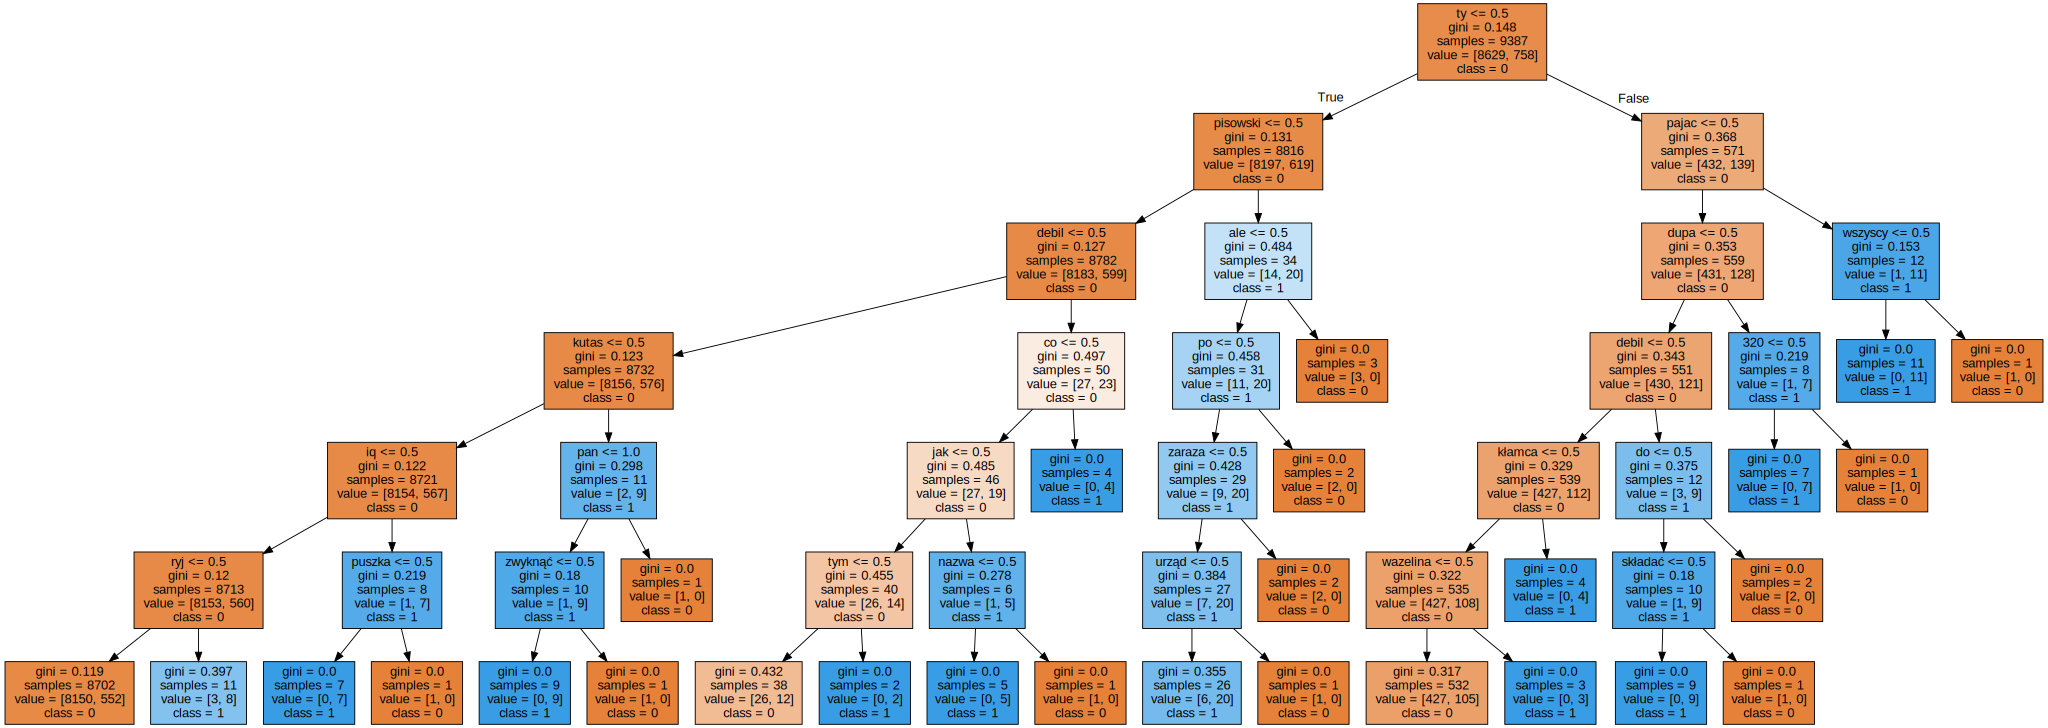

In [ ]:
dt_res[2]

In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, max_depth=10)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.884     0.998     0.937       824
           1      0.867     0.107     0.191       121

    accuracy                          0.884       945
   macro avg      0.875     0.553     0.564       945
weighted avg      0.882     0.884     0.842       945

[[822   2]
 [108  13]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.888     0.995     0.939       824
           1      0.818     0.149     0.252       121

    accuracy                          0.887       945
   macro avg      0.853     0.572     0.595       945
weighted avg      0.879     0.887     0.851       945

[[820   4]
 [103  18]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


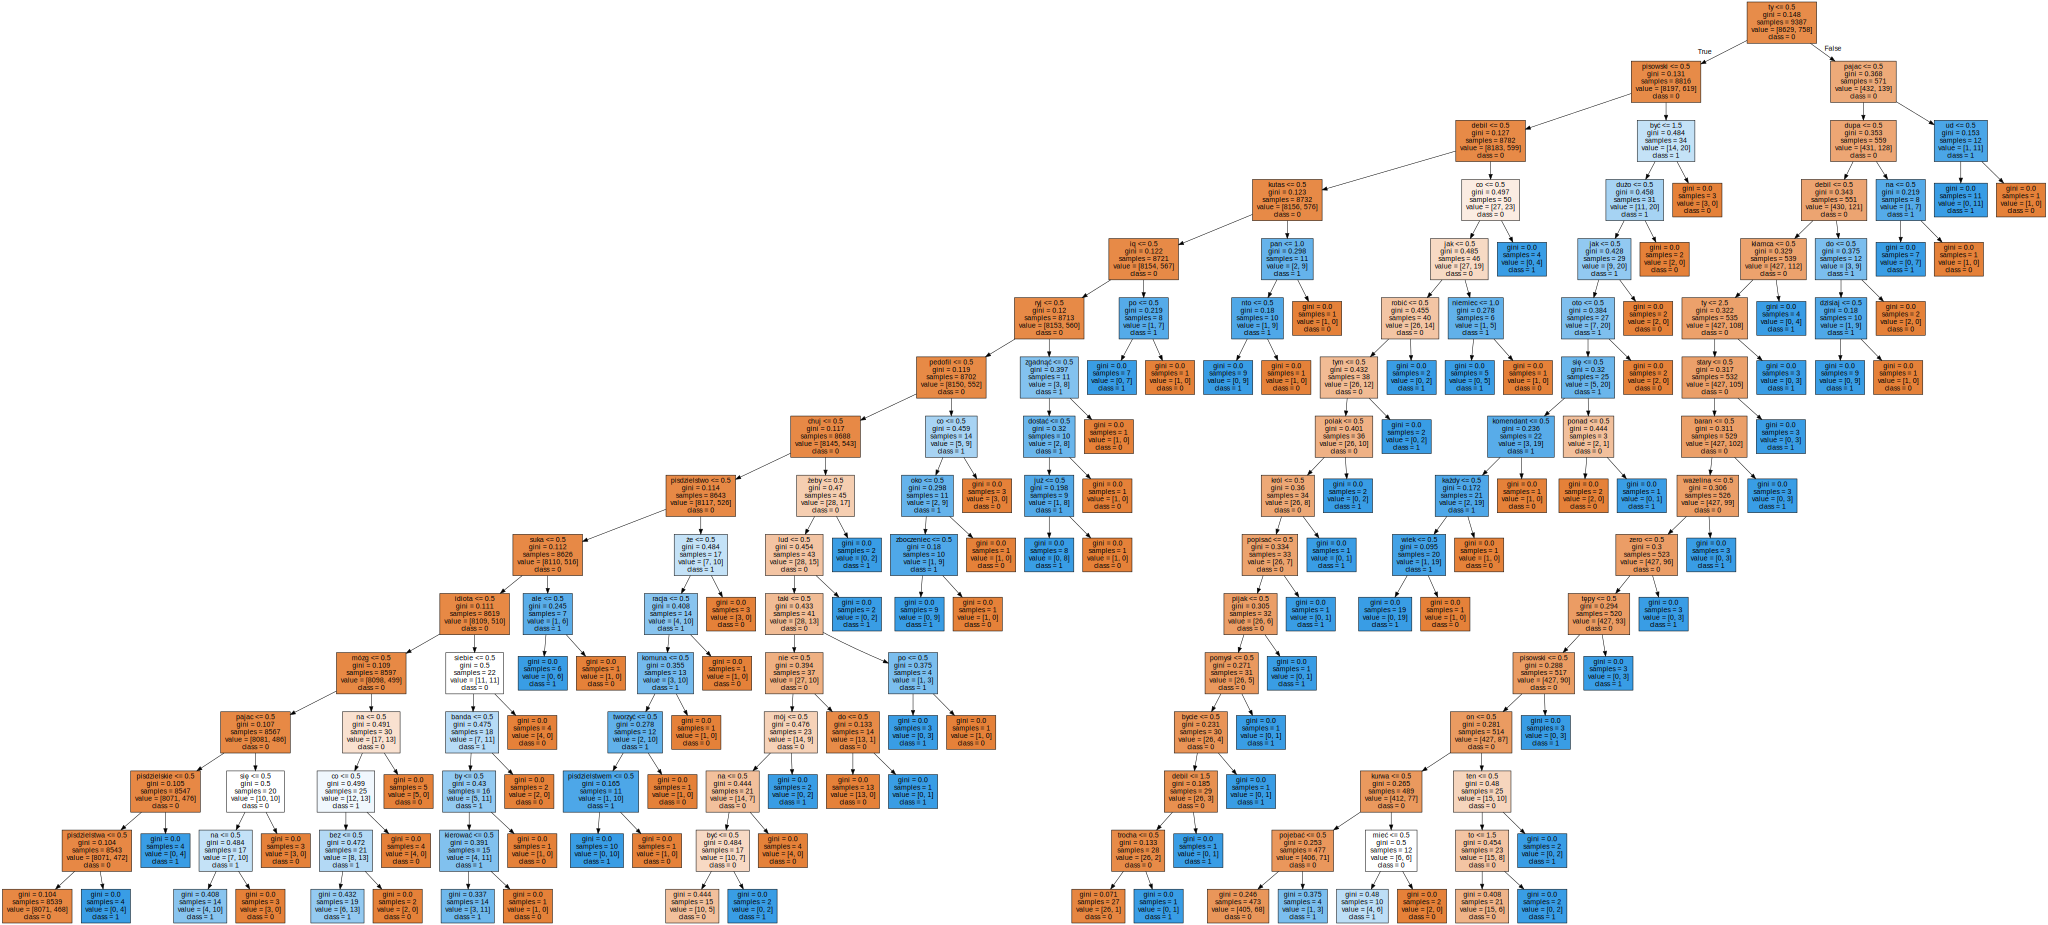

In [ ]:
dt_res[2]

In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, max_depth=20)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.890     0.995     0.940       824
           1      0.833     0.165     0.276       121

    accuracy                          0.889       945
   macro avg      0.862     0.580     0.608       945
weighted avg      0.883     0.889     0.855       945

[[820   4]
 [101  20]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, max_depth=25)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.892     0.994     0.940       824
           1      0.815     0.182     0.297       121

    accuracy                          0.890       945
   macro avg      0.853     0.588     0.619       945
weighted avg      0.882     0.890     0.858       945

[[819   5]
 [ 99  22]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, pruning=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.877     0.999     0.934       824
           1      0.857     0.050     0.094       121

    accuracy                          0.877       945
   macro avg      0.867     0.524     0.514       945
weighted avg      0.875     0.877     0.827       945

[[823   1]
 [115   6]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, pruning=True, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.888     0.995     0.939       824
           1      0.818     0.149     0.252       121

    accuracy                          0.887       945
   macro avg      0.853     0.572     0.595       945
weighted avg      0.879     0.887     0.851       945

[[820   4]
 [103  18]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, pruning=True, max_depth=20)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.889     0.995     0.939       824
           1      0.826     0.157     0.264       121

    accuracy                          0.888       945
   macro avg      0.858     0.576     0.602       945
weighted avg      0.881     0.888     0.853       945

[[820   4]
 [102  19]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, pruning=True, max_depth=25)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.892     0.993     0.940       824
           1      0.786     0.182     0.295       121

    accuracy                          0.889       945
   macro avg      0.839     0.587     0.617       945
weighted avg      0.878     0.889     0.857       945

[[818   6]
 [ 99  22]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, tfid=True, max_depth=10)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.886     0.998     0.938       824
           1      0.882     0.124     0.217       121

    accuracy                          0.886       945
   macro avg      0.884     0.561     0.578       945
weighted avg      0.885     0.886     0.846       945

[[822   2]
 [106  15]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, tfid=True, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.890     0.990     0.937       824
           1      0.714     0.165     0.268       121

    accuracy                          0.885       945
   macro avg      0.802     0.578     0.603       945
weighted avg      0.867     0.885     0.852       945

[[816   8]
 [101  20]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, tfid=True, max_depth=20)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.891     0.988     0.937       824
           1      0.677     0.174     0.276       121

    accuracy                          0.884       945
   macro avg      0.784     0.581     0.607       945
weighted avg      0.863     0.884     0.852       945

[[814  10]
 [100  21]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, tfid=True, max_depth=25)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.892     0.988     0.937       824
           1      0.688     0.182     0.288       121

    accuracy                          0.885       945
   macro avg      0.790     0.585     0.612       945
weighted avg      0.865     0.885     0.854       945

[[814  10]
 [ 99  22]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.88      1.00      0.93       824
           1       0.83      0.04      0.08       121

    accuracy                           0.88       945
   macro avg       0.85      0.52      0.51       945
weighted avg       0.87      0.88      0.82       945

[[823   1]
 [116   5]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


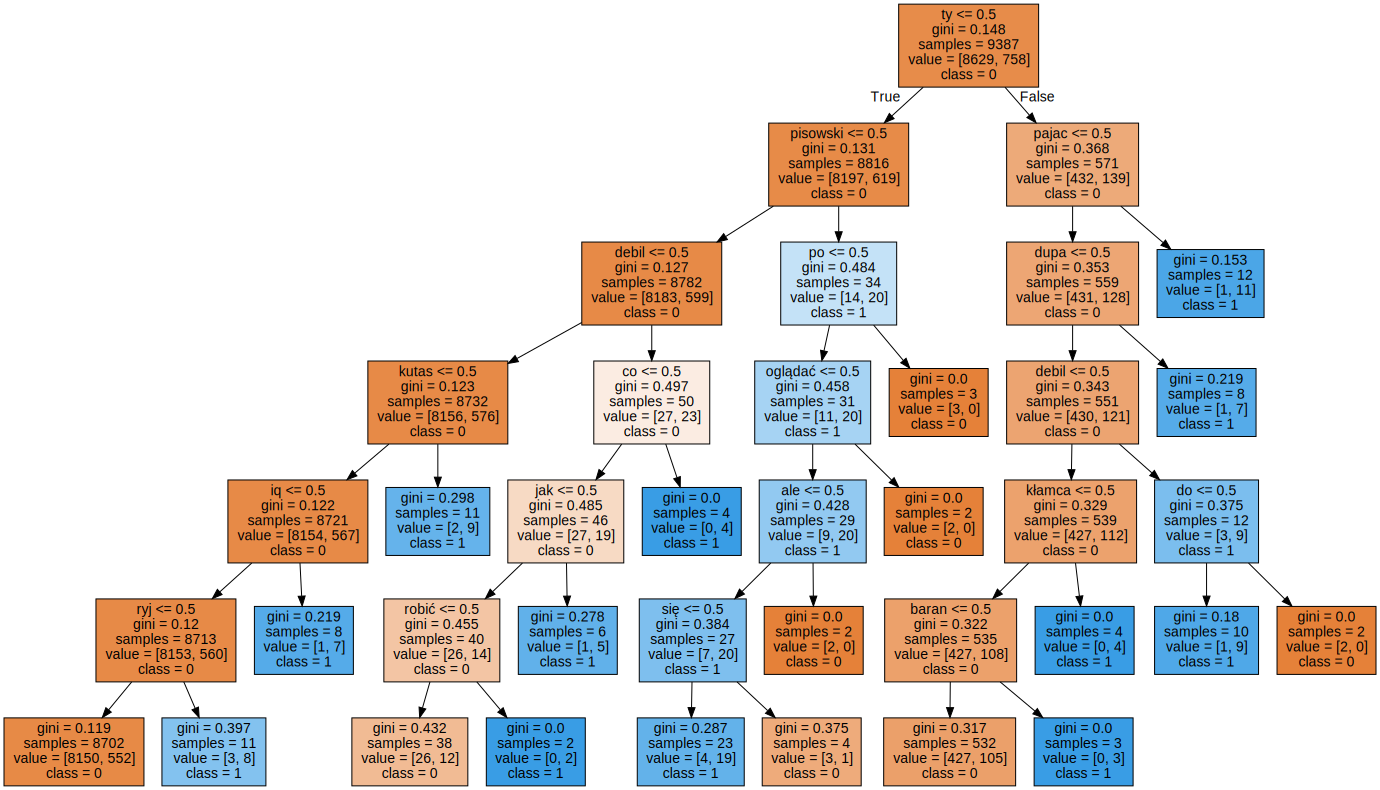

In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, pruning=True)
print(dt_res[0])
print(dt_res[1])
dt_res[2]

In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test, max_depth=20, pruning=True)
print(dt_res[0])
print(dt_res[1])


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       824
           1       0.86      0.16      0.27       121

    accuracy                           0.89       945
   macro avg       0.88      0.58      0.60       945
weighted avg       0.89      0.89      0.85       945

[[821   3]
 [102  19]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


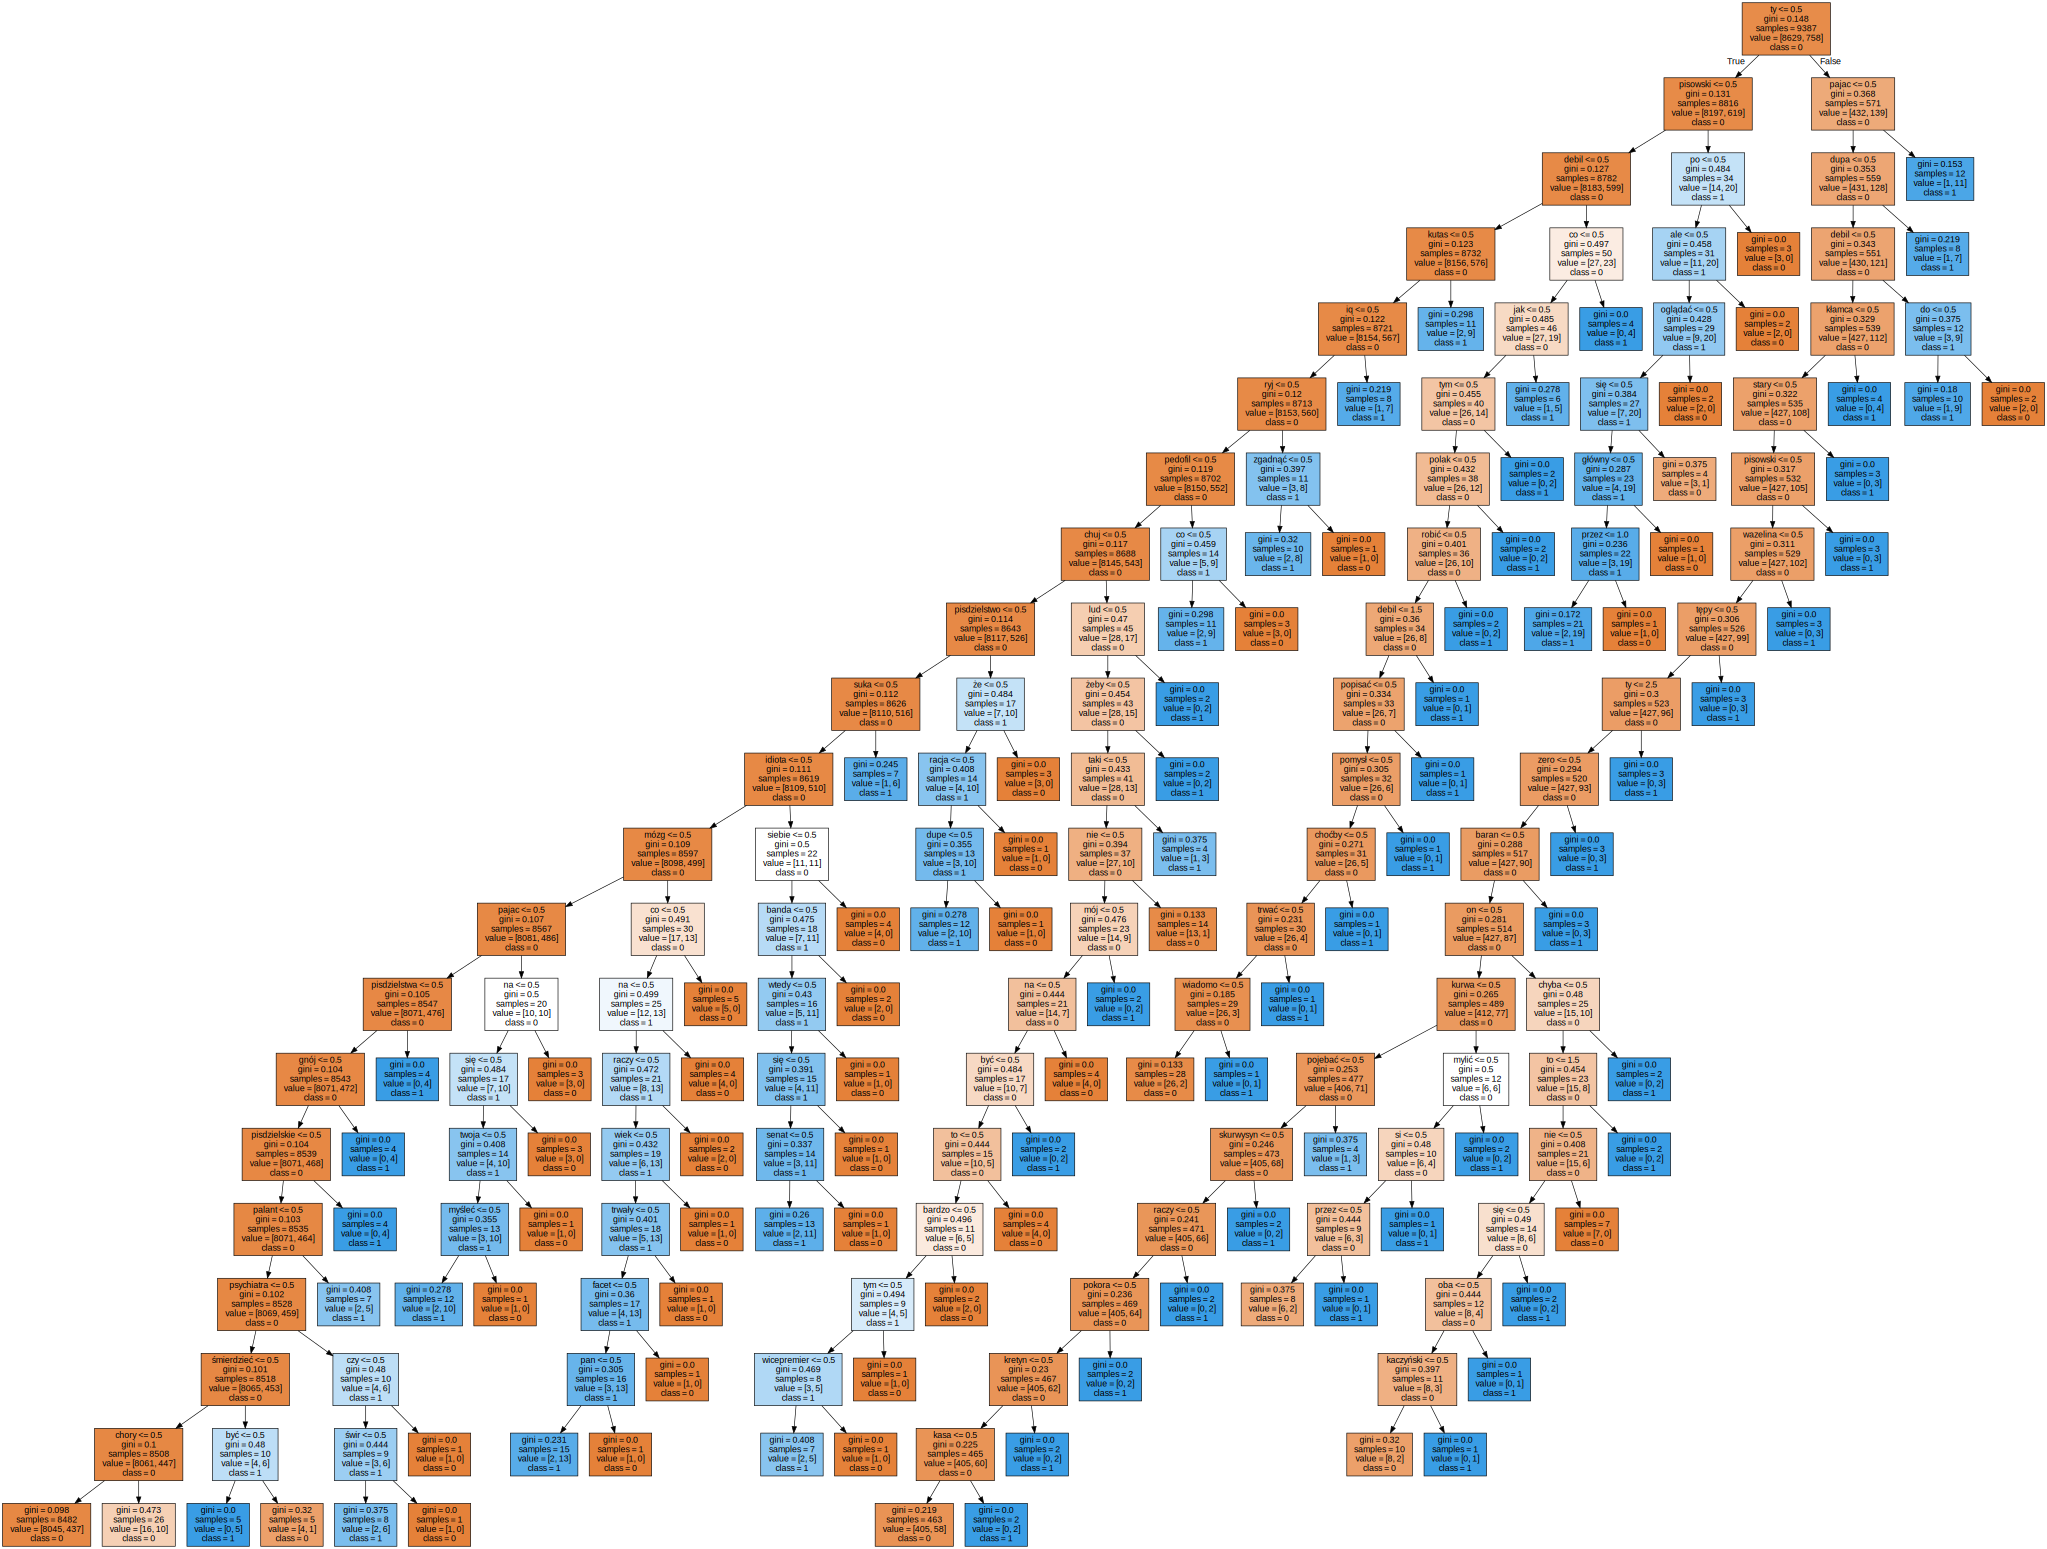

In [ ]:
dt_res[2]

In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=10)
print(dt_res[0])
print(dt_res[1])


              precision    recall  f1-score   support

           0       0.88      1.00      0.94       824
           1       0.87      0.11      0.19       121

    accuracy                           0.88       945
   macro avg       0.88      0.55      0.56       945
weighted avg       0.88      0.88      0.84       945

[[822   2]
 [108  13]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=20)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       824
           1       0.87      0.17      0.28       121

    accuracy                           0.89       945
   macro avg       0.88      0.58      0.61       945
weighted avg       0.89      0.89      0.86       945

[[821   3]
 [101  20]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=25)
print(dt_res[0])
print(dt_res[1])


              precision    recall  f1-score   support

           0       0.89      0.99      0.94       824
           1       0.80      0.17      0.27       121

    accuracy                           0.89       945
   macro avg       0.85      0.58      0.61       945
weighted avg       0.88      0.89      0.85       945

[[819   5]
 [101  20]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=30)
print(dt_res[0])
print(dt_res[1])


              precision    recall  f1-score   support

           0       0.89      0.99      0.94       824
           1       0.73      0.16      0.26       121

    accuracy                           0.88       945
   macro avg       0.81      0.57      0.60       945
weighted avg       0.87      0.88      0.85       945

[[817   7]
 [102  19]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=10, pruning=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       824
           1       0.86      0.10      0.18       121

    accuracy                           0.88       945
   macro avg       0.87      0.55      0.56       945
weighted avg       0.88      0.88      0.84       945

[[822   2]
 [109  12]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=20, pruning=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       824
           1       0.85      0.14      0.24       121

    accuracy                           0.89       945
   macro avg       0.87      0.57      0.59       945
weighted avg       0.88      0.89      0.85       945

[[821   3]
 [104  17]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=25, pruning=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       824
           1       0.78      0.15      0.25       121

    accuracy                           0.89       945
   macro avg       0.84      0.57      0.59       945
weighted avg       0.87      0.89      0.85       945

[[819   5]
 [103  18]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=30, pruning=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       824
           1       0.69      0.15      0.24       121

    accuracy                           0.88       945
   macro avg       0.79      0.57      0.59       945
weighted avg       0.86      0.88      0.85       945

[[816   8]
 [103  18]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=10, pruning=False, tfid=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       824
           1       0.88      0.12      0.22       121

    accuracy                           0.89       945
   macro avg       0.88      0.56      0.58       945
weighted avg       0.89      0.89      0.85       945

[[822   2]
 [106  15]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=20, pruning=False, tfid=True)
print(dt_res[0])
print(dt_res[1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.89      0.99      0.94       824
           1       0.69      0.15      0.24       121

    accuracy                           0.88       945
   macro avg       0.79      0.57      0.59       945
weighted avg       0.86      0.88      0.85       945

[[816   8]
 [103  18]]


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=25, pruning=False, tfid=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       824
           1       0.58      0.16      0.25       121

    accuracy                           0.88       945
   macro avg       0.73      0.57      0.59       945
weighted avg       0.85      0.88      0.85       945

[[810  14]
 [102  19]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=30, pruning=False, tfid=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       824
           1       0.65      0.18      0.28       121

    accuracy                           0.88       945
   macro avg       0.77      0.58      0.61       945
weighted avg       0.86      0.88      0.85       945

[[812  12]
 [ 99  22]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=10, pruning=True, tfid=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       824
           1       0.89      0.14      0.24       121

    accuracy                           0.89       945
   macro avg       0.89      0.57      0.59       945
weighted avg       0.89      0.89      0.85       945

[[822   2]
 [104  17]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=20, pruning=True, tfid=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       824
           1       0.66      0.16      0.25       121

    accuracy                           0.88       945
   macro avg       0.77      0.57      0.59       945
weighted avg       0.86      0.88      0.85       945

[[814  10]
 [102  19]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=25, pruning=True, tfid=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       824
           1       0.61      0.17      0.26       121

    accuracy                           0.88       945
   macro avg       0.75      0.57      0.60       945
weighted avg       0.85      0.88      0.85       945

[[811  13]
 [101  20]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dt_res = decision_tree(clean_train, clean_test, Y_train, Y_test,max_depth=30, pruning=True, tfid=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       824
           1       0.61      0.17      0.26       121

    accuracy                           0.88       945
   macro avg       0.75      0.57      0.60       945
weighted avg       0.85      0.88      0.85       945

[[811  13]
 [101  20]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### bagging

In [ ]:
def bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=10, max_samples=1.0):
  texts = []
  labels = []
                        
  X_train, X_test, y_train, y_test = clean_train, clean_test, Y_train, Y_test

  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)
  dt = BaggingClassifier(n_estimators=n_estimators, max_samples=max_samples)
  dt.fit(X_train, y_train)
  y_pred = dt.predict(X_test)
  report = classification_report(y_test, y_pred, digits=3)
  conf_matrix = confusion_matrix(y_test, y_pred)

  return report, conf_matrix, dt

In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.890     0.983     0.934       824
           1      0.600     0.174     0.269       121

    accuracy                          0.879       945
   macro avg      0.745     0.578     0.602       945
weighted avg      0.853     0.879     0.849       945

[[810  14]
 [100  21]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=10, max_samples=0.6)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.886     0.995     0.937       824
           1      0.789     0.124     0.214       121

    accuracy                          0.884       945
   macro avg      0.838     0.560     0.576       945
weighted avg      0.873     0.884     0.845       945

[[820   4]
 [106  15]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=10, max_samples=0.6)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.889     0.998     0.940       824
           1      0.900     0.149     0.255       121

    accuracy                          0.889       945
   macro avg      0.894     0.573     0.598       945
weighted avg      0.890     0.889     0.852       945

[[822   2]
 [103  18]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=50, max_samples=0.6)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.889     0.994     0.939       824
           1      0.792     0.157     0.262       121

    accuracy                          0.887       945
   macro avg      0.840     0.575     0.600       945
weighted avg      0.877     0.887     0.852       945

[[819   5]
 [102  19]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=100, max_samples=0.7)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.888     0.994     0.938       824
           1      0.783     0.149     0.250       121

    accuracy                          0.886       945
   macro avg      0.835     0.571     0.594       945
weighted avg      0.875     0.886     0.850       945

[[819   5]
 [103  18]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=10, max_samples=0.7)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.889     0.992     0.937       824
           1      0.731     0.157     0.259       121

    accuracy                          0.885       945
   macro avg      0.810     0.574     0.598       945
weighted avg      0.869     0.885     0.851       945

[[817   7]
 [102  19]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=50, max_samples=0.7)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.887     0.992     0.936       824
           1      0.708     0.140     0.234       121

    accuracy                          0.883       945
   macro avg      0.798     0.566     0.585       945
weighted avg      0.864     0.883     0.847       945

[[817   7]
 [104  17]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=10, max_samples=0.8)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.890     0.992     0.938       824
           1      0.741     0.165     0.270       121

    accuracy                          0.886       945
   macro avg      0.815     0.578     0.604       945
weighted avg      0.871     0.886     0.853       945

[[817   7]
 [101  20]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=50, max_samples=0.8)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.886     0.990     0.935       824
           1      0.667     0.132     0.221       121

    accuracy                          0.880       945
   macro avg      0.776     0.561     0.578       945
weighted avg      0.858     0.880     0.844       945

[[816   8]
 [105  16]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=50, max_samples=0.8)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.890     0.993     0.939       824
           1      0.769     0.165     0.272       121

    accuracy                          0.887       945
   macro avg      0.830     0.579     0.605       945
weighted avg      0.875     0.887     0.853       945

[[818   6]
 [101  20]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=100, max_samples=0.8)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.889     0.989     0.936       824
           1      0.679     0.157     0.255       121

    accuracy                          0.883       945
   macro avg      0.784     0.573     0.596       945
weighted avg      0.862     0.883     0.849       945

[[815   9]
 [102  19]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=100, max_samples=0.8)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.889     0.992     0.937       824
           1      0.731     0.157     0.259       121

    accuracy                          0.885       945
   macro avg      0.810     0.574     0.598       945
weighted avg      0.869     0.885     0.851       945

[[817   7]
 [102  19]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=300, max_samples=0.8)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.888     0.990     0.936       824
           1      0.692     0.149     0.245       121

    accuracy                          0.883       945
   macro avg      0.790     0.570     0.591       945
weighted avg      0.863     0.883     0.848       945

[[816   8]
 [103  18]]


In [ ]:
dt_res = bagging_decision_tree(clean_train, clean_test, Y_train, Y_test, n_estimators=100, max_samples=0.6)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.888     0.998     0.939       824
           1      0.895     0.140     0.243       121

    accuracy                          0.888       945
   macro avg      0.891     0.569     0.591       945
weighted avg      0.889     0.888     0.850       945

[[822   2]
 [104  17]]


### DT with balanced data

In [ ]:
Y_train_int = [int(i) for i in Y_train]
Y_test_int = [int(i) for i in Y_test]

In [ ]:
print(len(Y_train))
print(sum(Y_train_int))

9387
758


In [ ]:
def decision_tree_balanced_sets(clean_train, clean_test, Y_train, Y_test, number_of_runs=1, class_prop=0.7, max_depth=6, pruning=False, tfid=False, verbose=False):
  texts = []
  labels = []
                        
  X_train, X_test, y_train, y_test = clean_train, clean_test, Y_train, Y_test
  dt_arr = []
  only_ones = np.where(np.array(y_train) == 1)[0]
  only_zeros = np.where(np.array(y_train) == 0)[0]
  if tfid:
    vectorizer = TfidfVectorizer()
  else:
    vectorizer = CountVectorizer()

  X_train_vect = vectorizer.fit_transform(X_train)


  for i in range(number_of_runs):
    num_elem_balanced = int(only_ones.shape[0] * class_prop)
    choiced_elem_ones = np.random.choice(only_ones.shape[0], num_elem_balanced)
    choiced_elem_zeros = np.random.choice(only_zeros.shape[0], num_elem_balanced)

    idx_ones = only_ones[choiced_elem_ones]
    idx_zeros = only_zeros[choiced_elem_zeros]
    idx_all = np.append(idx_ones, idx_zeros)

    X_train_bag = X_train_vect[idx_all]
    Y_train_bag = np.array(Y_train)[idx_all]

    dt = DecisionTreeClassifier(max_depth = max_depth)
    dt.fit(X_train_bag, Y_train_bag)

    if pruning:

      def prune_index(inner_tree, index, threshold):
          if inner_tree.value[index].min() < threshold:
              inner_tree.children_left[index] = TREE_LEAF
              inner_tree.children_right[index] = TREE_LEAF
          if inner_tree.children_left[index] != TREE_LEAF:
              prune_index(inner_tree, inner_tree.children_left[index], threshold)
              prune_index(inner_tree, inner_tree.children_right[index], threshold)
      prune_index(dt.tree_, 0, 2)
    dt_arr.append(dt)
    
  X_test_vect = vectorizer.transform(X_test)
  
  y_pred_sum = np.zeros(np.array(Y_test).shape[0])
  for tree in dt_arr:  
    y_pred = tree.predict(X_test_vect)
    y_pred_sum += y_pred


  y_pred_sum = y_pred_sum/number_of_runs 
  y_pred_sum = [1 if i >= 0.5 else 0 for i in y_pred_sum]

  if verbose==True:
    for i in range(len(Y_test)):
      if Y_test[i] == 1 and y_pred_sum[i] == 1:
        print(X_test[i])


  report = classification_report(y_test, y_pred_sum, digits=3)
  conf_matrix = confusion_matrix(y_test, y_pred_sum)

  return report, conf_matrix, dt_arr


### many tests balanced tress

In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=10, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       824
           1       0.43      0.24      0.31       121

    accuracy                           0.86       945
   macro avg       0.66      0.60      0.61       945
weighted avg       0.84      0.86      0.84       945

[[785  39]
 [ 92  29]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=10, tfid=True, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       824
           1       0.48      0.25      0.33       121

    accuracy                           0.87       945
   macro avg       0.69      0.60      0.63       945
weighted avg       0.84      0.87      0.85       945

[[791  33]
 [ 91  30]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=100, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       824
           1       0.45      0.29      0.35       121

    accuracy                           0.86       945
   macro avg       0.67      0.62      0.64       945
weighted avg       0.84      0.86      0.85       945

[[781  43]
 [ 86  35]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=100, tfid=True, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       824
           1       0.45      0.29      0.35       121

    accuracy                           0.86       945
   macro avg       0.67      0.62      0.64       945
weighted avg       0.84      0.86      0.85       945

[[781  43]
 [ 86  35]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=200, max_depth=15, class_prop=0.5)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       824
           1       0.47      0.26      0.34       121

    accuracy                           0.87       945
   macro avg       0.68      0.61      0.63       945
weighted avg       0.84      0.87      0.85       945

[[788  36]
 [ 89  32]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=200, tfid=True, max_depth=15, pruning=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       824
           1       0.44      0.29      0.35       121

    accuracy                           0.86       945
   macro avg       0.67      0.62      0.64       945
weighted avg       0.84      0.86      0.85       945

[[779  45]
 [ 86  35]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=200, tfid=True, max_depth=15, pruning=True, class_prop=0.8)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       824
           1       0.48      0.28      0.35       121

    accuracy                           0.87       945
   macro avg       0.69      0.62      0.64       945
weighted avg       0.85      0.87      0.85       945

[[787  37]
 [ 87  34]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=200, tfid=True, max_depth=25, pruning=True, class_prop=0.9)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       824
           1       0.44      0.31      0.37       121

    accuracy                           0.86       945
   macro avg       0.67      0.63      0.64       945
weighted avg       0.84      0.86      0.85       945

[[775  49]
 [ 83  38]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=500, tfid=True, max_depth=30, pruning=True, class_prop=0.85)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       824
           1       0.45      0.31      0.36       121

    accuracy                           0.86       945
   macro avg       0.68      0.63      0.64       945
weighted avg       0.84      0.86      0.85       945

[[779  45]
 [ 84  37]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=True, max_depth=30, pruning=True, class_prop=0.80)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       824
           1       0.41      0.31      0.36       121

    accuracy                           0.86       945
   macro avg       0.66      0.62      0.64       945
weighted avg       0.84      0.86      0.85       945

[[770  54]
 [ 83  38]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=False, max_depth=30, pruning=False, class_prop=0.70)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.46      0.35      0.39       121

    accuracy                           0.86       945
   macro avg       0.68      0.64      0.66       945
weighted avg       0.85      0.86      0.86       945

[[774  50]
 [ 79  42]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=False, max_depth=25, pruning=False, class_prop=0.70)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.47      0.35      0.40       121

    accuracy                           0.87       945
   macro avg       0.69      0.64      0.66       945
weighted avg       0.85      0.87      0.86       945

[[776  48]
 [ 79  42]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=False, max_depth=25, pruning=False, class_prop=0.60)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       824
           1       0.47      0.33      0.39       121

    accuracy                           0.87       945
   macro avg       0.69      0.64      0.66       945
weighted avg       0.85      0.87      0.86       945

[[779  45]
 [ 81  40]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=False, max_depth=25, pruning=False, class_prop=0.65)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       824
           1       0.45      0.32      0.38       121

    accuracy                           0.86       945
   macro avg       0.68      0.63      0.65       945
weighted avg       0.85      0.86      0.85       945

[[777  47]
 [ 82  39]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=False, max_depth=25, pruning=True, class_prop=0.65)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       824
           1       0.45      0.32      0.38       121

    accuracy                           0.86       945
   macro avg       0.68      0.63      0.65       945
weighted avg       0.85      0.86      0.85       945

[[777  47]
 [ 82  39]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=500, tfid=False, max_depth=25, pruning=False, class_prop=0.65)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.46      0.34      0.39       121

    accuracy                           0.86       945
   macro avg       0.68      0.64      0.66       945
weighted avg       0.85      0.86      0.86       945

[[776  48]
 [ 80  41]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=500, tfid=False, max_depth=40, pruning=True, class_prop=0.65)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       824
           1       0.43      0.37      0.40       121

    accuracy                           0.86       945
   macro avg       0.67      0.65      0.66       945
weighted avg       0.85      0.86      0.85       945

[[764  60]
 [ 76  45]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=False, max_depth=25, pruning=False, class_prop=0.70)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.47      0.36      0.41       121

    accuracy                           0.87       945
   macro avg       0.69      0.65      0.67       945
weighted avg       0.85      0.87      0.86       945

[[774  50]
 [ 77  44]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=False, max_depth=25, pruning=False, class_prop=0.70)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.46      0.35      0.40       121

    accuracy                           0.86       945
   macro avg       0.68      0.64      0.66       945
weighted avg       0.85      0.86      0.86       945

[[775  49]
 [ 79  42]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=False, max_depth=25, pruning=False, class_prop=0.70)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.46      0.36      0.40       121

    accuracy                           0.86       945
   macro avg       0.68      0.65      0.66       945
weighted avg       0.85      0.86      0.86       945

[[773  51]
 [ 78  43]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=True, max_depth=25, pruning=True, class_prop=0.70)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       824
           1       0.40      0.31      0.35       121

    accuracy                           0.85       945
   macro avg       0.65      0.62      0.63       945
weighted avg       0.84      0.85      0.84       945

[[766  58]
 [ 83  38]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, tfid=False, max_depth=25, pruning=False, class_prop=0.70)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.46      0.36      0.41       121

    accuracy                           0.86       945
   macro avg       0.68      0.65      0.66       945
weighted avg       0.85      0.86      0.86       945

[[772  52]
 [ 77  44]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=100, tfid=False, 
                                     max_depth=25, pruning=False, class_prop=0.50)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.45      0.33      0.38       121

    accuracy                           0.86       945
   macro avg       0.68      0.64      0.65       945
weighted avg       0.85      0.86      0.85       945

[[776  48]
 [ 81  40]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=100, tfid=False, 
                                     max_depth=25, pruning=False, class_prop=0.60)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.46      0.36      0.40       121

    accuracy                           0.86       945
   macro avg       0.69      0.65      0.66       945
weighted avg       0.85      0.86      0.86       945

[[774  50]
 [ 78  43]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=100, tfid=False, 
                                     max_depth=25, pruning=False, class_prop=0.70)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.47      0.36      0.41       121

    accuracy                           0.87       945
   macro avg       0.69      0.65      0.67       945
weighted avg       0.85      0.87      0.86       945

[[775  49]
 [ 77  44]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=100, tfid=False, 
                                     max_depth=25, pruning=False, class_prop=0.80)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       824
           1       0.47      0.37      0.42       121

    accuracy                           0.87       945
   macro avg       0.69      0.66      0.67       945
weighted avg       0.85      0.87      0.86       945

[[774  50]
 [ 76  45]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=10, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.904     0.942     0.923       824
           1      0.448     0.322     0.375       121

    accuracy                          0.862       945
   macro avg      0.676     0.632     0.649       945
weighted avg      0.846     0.862     0.853       945

[[776  48]
 [ 82  39]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=10, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.903     0.924     0.913       824
           1      0.382     0.322     0.350       121

    accuracy                          0.847       945
   macro avg      0.643     0.623     0.631       945
weighted avg      0.836     0.847     0.841       945

[[761  63]
 [ 82  39]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=10, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.901     0.955     0.928       824
           1      0.486     0.289     0.363       121

    accuracy                          0.870       945
   macro avg      0.694     0.622     0.645       945
weighted avg      0.848     0.870     0.855       945

[[787  37]
 [ 86  35]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=100, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.901     0.954     0.927       824
           1      0.479     0.289     0.361       121

    accuracy                          0.869       945
   macro avg      0.690     0.622     0.644       945
weighted avg      0.847     0.869     0.854       945

[[786  38]
 [ 86  35]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=100, max_depth=15, tfid=True)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.901     0.942     0.921       824
           1      0.429     0.298     0.351       121

    accuracy                          0.859       945
   macro avg      0.665     0.620     0.636       945
weighted avg      0.841     0.859     0.848       945

[[776  48]
 [ 85  36]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=100, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.899     0.953     0.925       824
           1      0.458     0.273     0.342       121

    accuracy                          0.866       945
   macro avg      0.679     0.613     0.634       945
weighted avg      0.843     0.866     0.850       945

[[785  39]
 [ 88  33]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, max_depth=15)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.900     0.945     0.922       824
           1      0.430     0.281     0.340       121

    accuracy                          0.860       945
   macro avg      0.665     0.613     0.631       945
weighted avg      0.839     0.860     0.847       945

[[779  45]
 [ 87  34]]


In [ ]:
dt_res = decision_tree_balanced_sets(clean_train, clean_test, Y_train_int, Y_test_int, number_of_runs=300, max_depth=25)
print(dt_res[0])
print(dt_res[1])

              precision    recall  f1-score   support

           0      0.908     0.938     0.923       824
           1      0.457     0.355     0.400       121

    accuracy                          0.863       945
   macro avg      0.683     0.647     0.661       945
weighted avg      0.851     0.863     0.856       945

[[773  51]
 [ 78  43]]
